In [1]:
import torch
from torch.optim import Adam

import math
from tqdm import trange

from onequbitgates import GeneralOneQubitGate

def fidelity(state_vector, gate, bad_gate):
    op = gate.T.conj() @ bad_gate @ gate
    
#     print(state_vector.conj() @ op @ state_vector)
    return state_vector.conj() @ gate.T.conj() @ bad_gate @ gate @ state_vector

In [5]:
THETA = 0.5
PHI = 0.5
BETA = 1.
GAMMA = 2.
DELTA = 3.

I = torch.tensor([[1, 0],
                  [0, 1]], dtype=torch.cfloat, requires_grad=False)
X = torch.tensor([[0, 1],
                  [1, 0]], dtype=torch.cfloat, requires_grad=False)
Y = torch.tensor([[0, -1j],
                  [1j, 0]], dtype=torch.cfloat, requires_grad=False)
Z = torch.tensor([[1, 0],
                  [0, -1]], dtype=torch.cfloat, requires_grad=False)

def rx(angle):
    return math.cos(angle/2) * I - 1j * math.sin(angle/2) * X

def ry(angle):
    return math.cos(angle/2) * I - 1j * math.sin(angle/2) * Y

def rz(angle):
    return math.cos(angle/2) * I - 1j * math.sin(angle/2) * Z

state = torch.tensor([THETA, PHI], dtype=torch.cfloat, requires_grad=False)
state_vector = torch.tensor([math.cos(THETA/2), math.sin(THETA/2)*math.e**(1j*PHI)], dtype=torch.cfloat, requires_grad=False)
rho = torch.tensordot(state_vector.conj(), state_vector, dims=0)
gate = rz(BETA) @ rx(-math.pi/2) @ rz(GAMMA) @ rx(math.pi/2) @ rz(DELTA)

bad_gate = GeneralOneQubitGate().float() # torch.tensor([BETA, GAMMA, DELTA])
optim = Adam(bad_gate.parameters())

In [6]:
fidelities = []
purities = []

for i in trange(3000):
    bad_rho = bad_gate(rho)
    loss = -fidelity(state_vector, gate, bad_rho)
    loss.backward()
    
    optim.step()
    optim.zero_grad()
    
    with torch.no_grad():
        fidelities.append(-loss.item().real)
        purities.append(torch.trace(bad_rho.T.conj() @ bad_rho).item().real)

100%|██████████| 3000/3000 [00:03<00:00, 980.51it/s] 


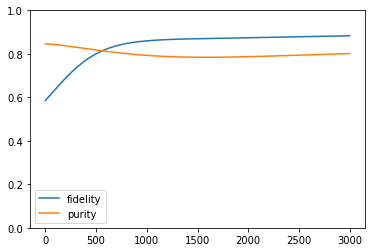

In [7]:
import matplotlib.pyplot as plt

plt.plot(fidelities, label="fidelity")
plt.plot(purities, label="purity")
plt.ylim((0,1))
plt.legend()
plt.show()